In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as s
import matplotlib.patches as mpatches
import math
import csv
import os
import opendssdirect as dss
from opendssdirect.utils import run_command
import types
import matplotlib.pyplot as plt
import inspect

In [ ]:
# loadshapes paths
office_path = "../data/consumption/loadshapes/office_building_loadshape_values.csv" 
park_path = "../data/consumption/loadshapes/industrial_park_loadshape_values.csv"
shops_path"../data/consumption/loadshapes/shops_loadshape_values.csv"
fve_path = "../data/production/loadshapes/FVE_loadshape_values.csv"
mve_path = "../data/production/loadshapes/MVE_loadshape_values.csv"
wpg_path = "../data/production/loadshapes/WPG_loadshape_values.csv"

In [39]:
df = pd.read_csv("../data/data_fake_withPredictions_withClustering.csv")

In [40]:
df.head()

,date,shops,office_building,industrial_park,fve,mve,wpg,price,isWeekend,isHoliday,...,month_sin,1_step_prod,1_step_cons,2_step_prod,2_step_cons,3_step_prod,3_step_cons,4_step_prod,4_step_cons,clusters
0,2020-01-01 00:00:00,16.0236,44.6160,19.8440,0.0,243.7380,8.1108,33.2,0,1,...,-0.008601,0.433352,0.064990,0.441481,0.073064,0.441725,0.073677,0.435342,0.067344,0
1,2020-01-01 00:15:00,11.6640,37.9080,15.4188,0.0,264.5154,8.0586,33.2,0,1,...,-0.008422,0.435380,0.063490,0.442430,0.070368,0.442431,0.070776,0.437029,0.065436,0
2,2020-01-01 00:30:00,11.6460,45.9888,14.6196,0.0,263.1303,7.3188,33.2,0,1,...,-0.008243,0.438423,0.065931,0.442592,0.069759,0.444355,0.072045,0.438500,0.066208,0
3,2020-01-01 00:45:00,11.7900,37.6272,14.3676,0.0,320.5708,8.2379,33.2,0,1,...,-0.008064,0.440430,0.065731,0.443618,0.068465,0.444856,0.070257,0.440422,0.065868,0
4,2020-01-01 01:00:00,16.0200,37.6272,23.0252,0.0,265.8654,6.6474,30.4,0,1,...,-0.007884,0.440370,0.065280,0.445127,0.069583,0.444780,0.069737,0.441198,0.066193,0


In [38]:
for day in range(int(len(df)/96)):
    day_start = day
    day_end = day+96
    print(df.loc[day:day_end, "index"])
    break

KeyError: 'index'

In [22]:
# setup loadshapes 


# compile
run_command("Compile 'microgrid.dss'")

# init battery controll shape
dates = []
dss.run_command('''
        New LoadShape.SC_loadshape 
        interval=1 
        npts=96 
        mult=[-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
        ''')
dss.run_command('''
        New StorageController.SC 
        element=Line.L1 
        terminal=1 
        modedis=loadshape 
        daily=SC_loadshape 
        %rateCharge=100 
        %reserve=20 
        eventlog=yes
''')

# dss variables
dss.run_command('Set controlmode=time')
dss.run_command('Set mode=daily ')
dss.run_command('Set stepsize=15m')
dss.run_command('Set number=96')
dss.run_command('Solve');

# export data
trafo_path = dss.run_command('Export monitor object=trafo')
battery_path = dss.run_command('Export monitor object=baterry')
trafo_df = pd.read_csv(trafo_path)
battery_df = pd.read_csv(battery_path)

trafo_df = trafo_df[['P1 (kW)']]
battery_df = battery_df[['kWOut', 'kWIn']]
df = battery_df.copy()
df['kW'] = trafo_df['P1 (kW)']
# concat data

# next

In [25]:
df.head(50)

,kWOut,kWIn,kW
0,0.00000,0.00000,-89.915900
1,0.00000,0.00000,-107.778000
2,0.00000,0.00000,-107.619000
3,0.00000,0.00000,-106.798000
4,0.00000,0.00000,-99.303100
5,0.00000,0.00000,-108.671000
6,0.00000,0.00000,-106.856000
7,0.00000,10.00000,-94.843000
8,0.00000,9.99999,-93.186100
9,0.00000,10.00000,-92.870700


In [16]:
print(df.columns)
df.head(10)

Index(['hour', 't(sec)', 'P1 (kW)', 'Q1 (kvar)'], dtype='object')


,hour,t(sec),P1 (kW),Q1 (kvar)
0,0,900.0,-89.9159,-17.4160
1,0,1800.0,-107.7780,-20.9735
2,0,2700.0,-107.6190,-20.9543
3,1,0.0,-106.7980,-20.7913
4,1,900.0,-99.3031,-19.1889
5,1,1800.0,-108.6710,-21.1575
6,1,2700.0,-106.8560,-20.7966
7,2,0.0,-94.8430,-20.4474
8,2,900.0,-93.1861,-20.1024
9,2,1800.0,-92.8707,-20.0424


In [21]:
print(batery.columns)
batery[['kWOut', 'kWIn']].head(50)

Index(['hour', 't(sec)', 'kWh', 'State', 'kWOut', 'kWIn', 'kvarOut', 'DCkW',
       'kWTotalLosses', 'kWInvLosses', 'kWIdlingLosses', 'kWChDchLosses',
       'kWh Chng', 'InvEff', 'InverterON', 'Vref', 'Vavg (DRC)', 'VV Oper',
       'VW Oper', 'DRC Oper', 'VV_DRC Oper', 'WP Oper', 'WV Oper', 'kWDesired',
       'kW VW Limit', 'Limit kWOut Function', 'kVA Exceeded'],
      dtype='object')


,kWOut,kWIn
0,0.00000,0.00000
1,0.00000,0.00000
2,0.00000,0.00000
3,0.00000,0.00000
4,0.00000,0.00000
5,0.00000,0.00000
6,0.00000,0.00000
7,0.00000,10.00000
8,0.00000,9.99999
9,0.00000,10.00000


299.99969


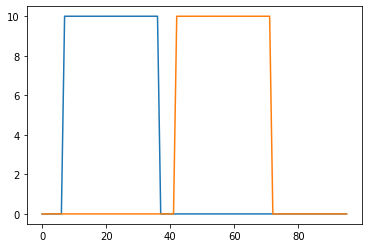

In [9]:
print(batery['kWIn'].sum())
batery['kWIn'].plot()
batery['kWOut'].plot()
plt.show()